In [1]:
from utils import *
from experiment import *

import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
plt.style.use("light")

PATH = "/home/max/Temp/Praktikum/longitudinal/"
SAVE_PATH = "/home/max/Nextcloud/Praktikum/Report/figures/"
REPEAT = 3

# Single Experiment Run

528


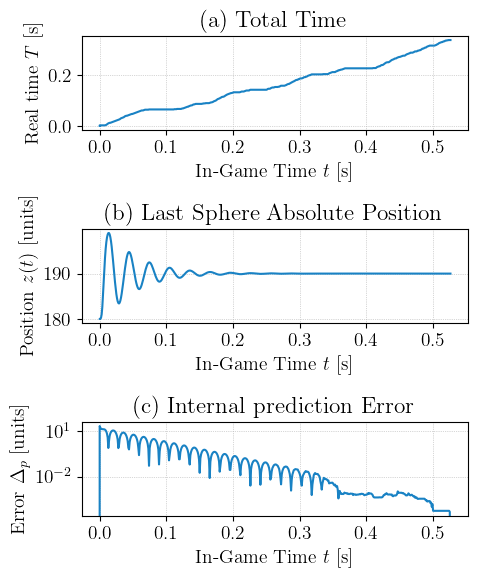

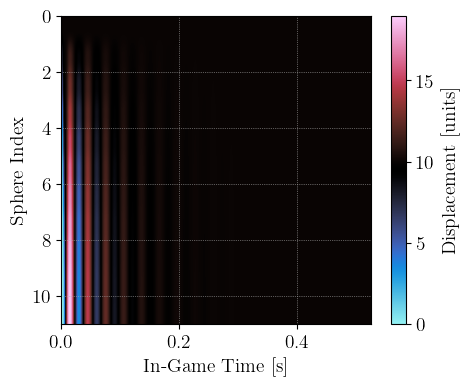

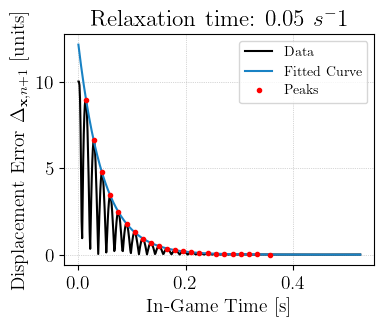

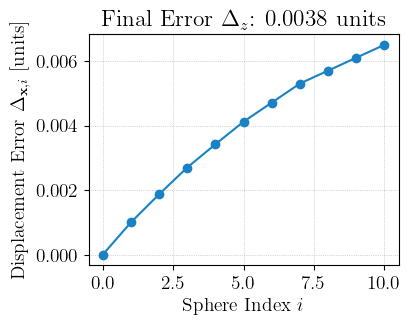

In [2]:
positions = read_json_file(PATH + "constraint_solver_steps_0/constraint_solver_steps_0_100/positions.json")

experiment1 = GuidewireExperiment(positions)

print(experiment1.timesteps)

experiment1.plot_experiment(axis=2)
plt.savefig(SAVE_PATH + "experiment1.pdf", bbox_inches="tight", dpi=300)
plt.show()

experiment1.plot_all_spheres(axis=2)
plt.savefig(SAVE_PATH + "experiment1_2.pdf", bbox_inches="tight", dpi=300)
plt.show()

_ = get_decay_rate(experiment1, [1,1], debug=True, offset=10, save=True)

# Constraint Solver Steps

In [3]:
constraint_solver_steps = np.arange(100,1100,100)

relaxation_times, offsets, loop_times, errors, params = get_all_data("constraint_solver_steps", constraint_solver_steps, REPEAT, PATH, debug=False)

/home/max/Temp/Praktikum/longitudinal/constraint_solver_steps_0/constraint_solver_steps_0_100
Timesteps:  528
/home/max/Temp/Praktikum/longitudinal/constraint_solver_steps_0/constraint_solver_steps_0_200
Timesteps:  192
/home/max/Temp/Praktikum/longitudinal/constraint_solver_steps_0/constraint_solver_steps_0_300
Timesteps:  134
/home/max/Temp/Praktikum/longitudinal/constraint_solver_steps_0/constraint_solver_steps_0_400
Timesteps:  223
/home/max/Temp/Praktikum/longitudinal/constraint_solver_steps_0/constraint_solver_steps_0_500
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/constraint_solver_steps_0/constraint_solver_steps_0_600
Timesteps:  68
/home/max/Temp/Praktikum/longitudinal/constraint_solver_steps_0/constraint_solver_steps_0_700
Timesteps:  79
/home/max/Temp/Praktikum/longitudinal/constraint_solver_steps_0/constraint_solver_steps_0_800
Timesteps:  69
/home/max/Temp/Praktikum/longitudinal/constraint_solver_steps_0/constraint_solver_steps_0_900
Timesteps:  48
/home/max/Temp

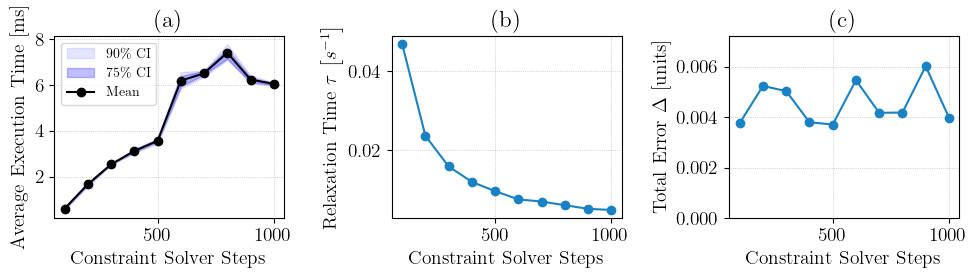

In [4]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

xlabel = "Constraint Solver Steps"

plot_confidence_interval(ax[0], constraint_solver_steps, loop_times)

ax[1].plot(constraint_solver_steps, relaxation_times[0], "o-")

ax[2].plot(constraint_solver_steps, errors[0], "o-")
ax[2].set_ylim(0, errors[0].max()*1.2)

set_labels(ax, xlabel)

plt.tight_layout()
plt.savefig(SAVE_PATH + "constraint_solver_steps.png", dpi=300, bbox_inches="tight")
plt.show()

# Time steps

In [5]:
timesteps = np.logspace(-4, 0, 10)

relaxation_times, offsets, loop_times, errors, params = get_all_data("time_steps", timesteps, REPEAT, PATH, debug=False)

/home/max/Temp/Praktikum/longitudinal/time_steps_0/time_steps_0_0.0001
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/time_steps_0/time_steps_0_0.0002782559402207126
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/time_steps_0/time_steps_0_0.000774263682681127
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/time_steps_0/time_steps_0_0.002154434690031882
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/time_steps_0/time_steps_0_0.005994842503189409
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/time_steps_0/time_steps_0_0.016681005372000592
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/time_steps_0/time_steps_0_0.046415888336127774
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/time_steps_0/time_steps_0_0.12915496650148828
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/time_steps_0/time_steps_0_0.3593813663804626
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/time_steps_0/time_steps_0_1.0
Timesteps:  359
/home/max/Temp/Praktiku

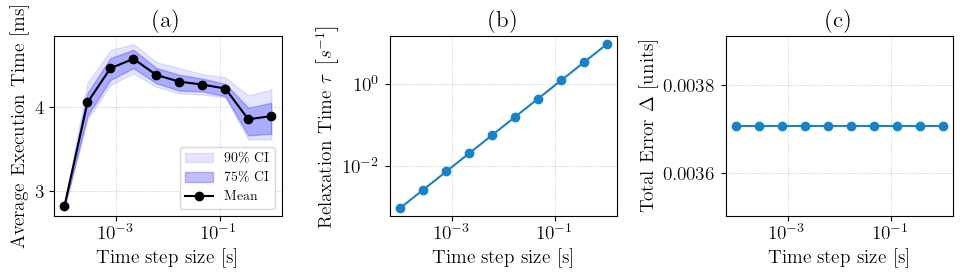

In [6]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

xlabel = "Time step size [s]"

plot_confidence_interval(ax[0], timesteps, loop_times)
ax[0].set_xscale("log")

ax[1].plot(timesteps, relaxation_times[0], "o-")
ax[1].set_xscale("log")
ax[1].set_yscale("log")

ax[2].plot(timesteps, errors[0], "o-")
ax[2].set_xscale("log")

set_labels(ax, xlabel)

plt.tight_layout()
plt.savefig(SAVE_PATH + "time_steps_total_time.png", dpi=300, bbox_inches="tight")
plt.show()

# Rod Element Length

In [7]:
elements = np.arange(4,40,2, dtype="int").astype("float")

relaxation_times, offsets, loop_times, errors, params = get_all_data("rod_elements", elements, REPEAT, PATH, debug=False)

/home/max/Temp/Praktikum/longitudinal/rod_elements_0/rod_elements_0_4.0
Timesteps:  138
/home/max/Temp/Praktikum/longitudinal/rod_elements_0/rod_elements_0_6.0
Timesteps:  94
/home/max/Temp/Praktikum/longitudinal/rod_elements_0/rod_elements_0_8.0
Timesteps:  95
/home/max/Temp/Praktikum/longitudinal/rod_elements_0/rod_elements_0_10.0
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/rod_elements_0/rod_elements_0_12.0
Timesteps:  82
/home/max/Temp/Praktikum/longitudinal/rod_elements_0/rod_elements_0_14.0
Timesteps:  112
/home/max/Temp/Praktikum/longitudinal/rod_elements_0/rod_elements_0_16.0
Timesteps:  118
/home/max/Temp/Praktikum/longitudinal/rod_elements_0/rod_elements_0_18.0
Timesteps:  265
/home/max/Temp/Praktikum/longitudinal/rod_elements_0/rod_elements_0_20.0
Timesteps:  325
/home/max/Temp/Praktikum/longitudinal/rod_elements_0/rod_elements_0_22.0
Timesteps:  176
/home/max/Temp/Praktikum/longitudinal/rod_elements_0/rod_elements_0_24.0
Timesteps:  208
/home/max/Temp/Praktikum/lo

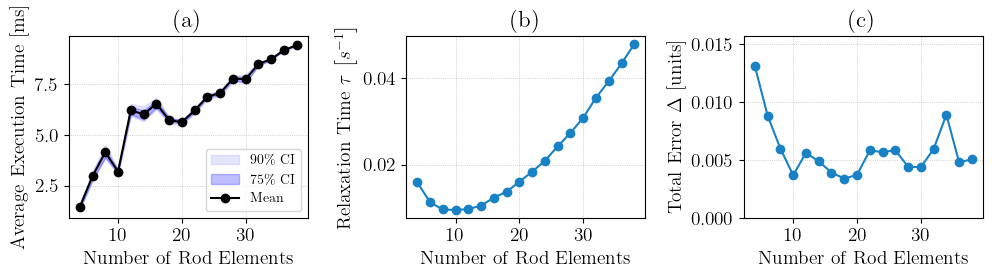

In [8]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

xlabel = "Number of Rod Elements"

plot_confidence_interval(ax[0], elements, loop_times)

ax[1].plot(elements, relaxation_times[0], "o-")

ax[2].plot(elements, errors[0], "o-")
ax[2].set_ylim(0, errors[0].max()*1.2)

set_labels(ax, xlabel)

plt.tight_layout()

plt.savefig("/home/max/Nextcloud/Praktikum/Report/figures/rod_elements.png", dpi=300, bbox_inches="tight")
plt.show()

# Displacement

In [9]:
displacements = np.linspace(1,10, 10)[1:]

relaxation_times, offsets, loop_times, errors, params = get_all_data("displacemen", displacements, REPEAT, PATH, debug=False)

/home/max/Temp/Praktikum/longitudinal/displacemen_0/displacemen_0_2.0
Timesteps:  90
/home/max/Temp/Praktikum/longitudinal/displacemen_0/displacemen_0_3.0
Timesteps:  100
/home/max/Temp/Praktikum/longitudinal/displacemen_0/displacemen_0_4.0
Timesteps:  85
/home/max/Temp/Praktikum/longitudinal/displacemen_0/displacemen_0_5.0
Timesteps:  77
/home/max/Temp/Praktikum/longitudinal/displacemen_0/displacemen_0_6.0
Timesteps:  174
/home/max/Temp/Praktikum/longitudinal/displacemen_0/displacemen_0_7.0
Timesteps:  99
/home/max/Temp/Praktikum/longitudinal/displacemen_0/displacemen_0_8.0
Timesteps:  89
/home/max/Temp/Praktikum/longitudinal/displacemen_0/displacemen_0_9.0
Timesteps:  88
/home/max/Temp/Praktikum/longitudinal/displacemen_0/displacemen_0_10.0
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/displacemen_1/displacemen_1_2.0
Timesteps:  90
/home/max/Temp/Praktikum/longitudinal/displacemen_1/displacemen_1_3.0
Timesteps:  100
/home/max/Temp/Praktikum/longitudinal/displacemen_1/displace

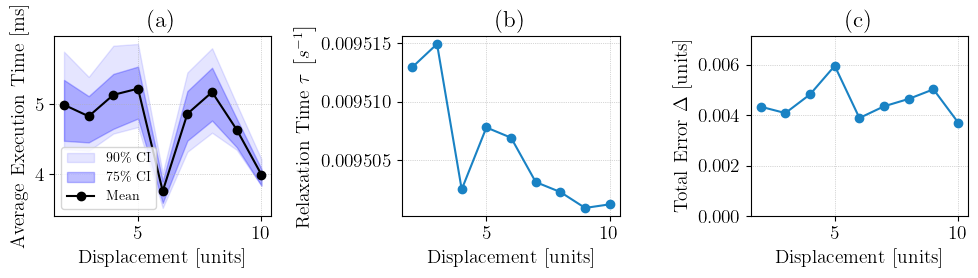

In [10]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

xlabel = "Displacement [units]"

plot_confidence_interval(ax[0], displacements, loop_times)

ax[1].plot(displacements, relaxation_times[0], "o-")

ax[2].plot(displacements, errors[0], "o-")
ax[2].set_ylim(0, errors[0].max()*1.2)

set_labels(ax, xlabel)

plt.tight_layout()

plt.savefig("/home/max/Nextcloud/Praktikum/Report/figures/displacements.png", dpi=300, bbox_inches="tight")
plt.show()

# Total mass

In [11]:
masses = np.linspace(0.01,5,10)

relaxation_times, offsets, loop_times, errors, params = get_all_data("total_mass", masses, REPEAT, PATH, debug=False)

/home/max/Temp/Praktikum/longitudinal/total_mass_0/total_mass_0_0.01
Timesteps:  359
/home/max/Temp/Praktikum/longitudinal/total_mass_0/total_mass_0_0.5644444444444445
Timesteps:  1002
/home/max/Temp/Praktikum/longitudinal/total_mass_0/total_mass_0_1.118888888888889
Timesteps:  1002
/home/max/Temp/Praktikum/longitudinal/total_mass_0/total_mass_0_1.6733333333333336
Timesteps:  1002
/home/max/Temp/Praktikum/longitudinal/total_mass_0/total_mass_0_2.227777777777778
Timesteps:  1002
/home/max/Temp/Praktikum/longitudinal/total_mass_0/total_mass_0_2.7822222222222224
Timesteps:  1002
/home/max/Temp/Praktikum/longitudinal/total_mass_0/total_mass_0_3.336666666666667
Timesteps:  1002
/home/max/Temp/Praktikum/longitudinal/total_mass_0/total_mass_0_3.8911111111111114
Timesteps:  1002
/home/max/Temp/Praktikum/longitudinal/total_mass_0/total_mass_0_4.445555555555556
Timesteps:  1002
/home/max/Temp/Praktikum/longitudinal/total_mass_0/total_mass_0_5.0
Timesteps:  1002
/home/max/Temp/Praktikum/longitudi

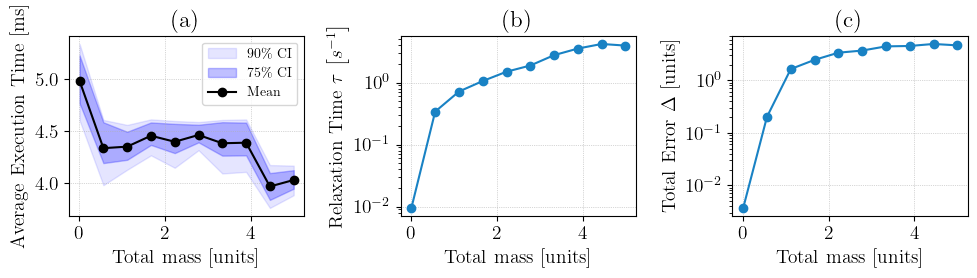

In [12]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

xlabel = "Total mass [units]"

plot_confidence_interval(ax[0], masses, loop_times)

ax[1].plot(masses, relaxation_times[0], "o-")
ax[1].set_yscale("log")

ax[2].plot(masses, errors[0], "o-")
ax[2].set_yscale("log")

set_labels(ax, xlabel)

plt.tight_layout()

plt.savefig("/home/max/Nextcloud/Praktikum/Report/figures/total_masses.png", dpi=300, bbox_inches="tight")
plt.show()